# This test is to be able to replicate and compare the outcomes of the original test T-005-A Optimise NN, to confirm replicability and system performance across different computing hardware and python versions.

Result: We find with the Standard model it tend to predict Normal labels better but with SMOTE we can force the model to prioritise threats without a significant impact on false predictions on Normal labels.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\kregh\AppData\Local\Temp\ipykernel_17648\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [9]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# STANDARD TUNING

Epoch 1/5: 100%|██████████| 15876/15876 [01:57<00:00, 135.08batch/s]


Epoch [1/5], Train Loss: 0.0182, Train Acc: 0.9903, Train F1: 0.9901


Epoch 2/5: 100%|██████████| 15876/15876 [01:55<00:00, 137.78batch/s]


Epoch [2/5], Train Loss: 0.0172, Train Acc: 0.9904, Train F1: 0.9902


Epoch 3/5: 100%|██████████| 15876/15876 [02:01<00:00, 131.15batch/s]


Epoch [3/5], Train Loss: 0.0171, Train Acc: 0.9906, Train F1: 0.9903


Epoch 4/5: 100%|██████████| 15876/15876 [02:04<00:00, 127.70batch/s]


Epoch [4/5], Train Loss: 0.0171, Train Acc: 0.9900, Train F1: 0.9897


Epoch 5/5: 100%|██████████| 15876/15876 [02:02<00:00, 129.62batch/s]


Epoch [5/5], Train Loss: 0.0176, Train Acc: 0.9897, Train F1: 0.9894


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 199.29batch/s]


Test Loss: 0.0179, Test Accuracy: 0.9897, Test F1: 0.9894


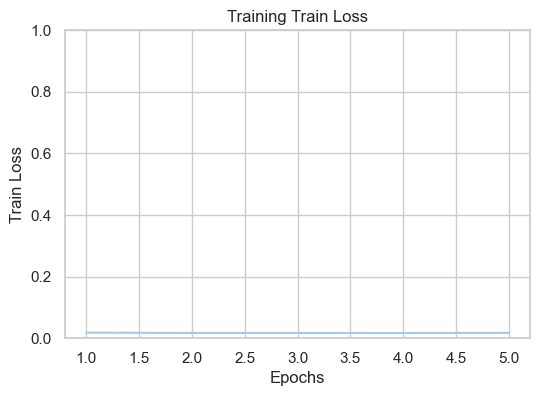

Standard Test


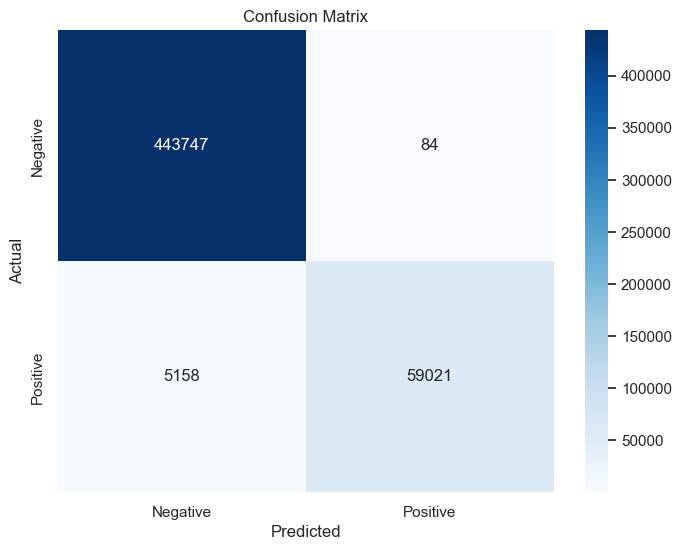

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/01'
modelst1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.1
epochs = 5
save_factor = 1
modelst1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelst1.test(test_loader)
plot_metrics(modelst1.train_loss, len(modelst1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelst1.test_predicted)

Epoch 1/20: 100%|██████████| 15876/15876 [02:01<00:00, 130.96batch/s]


Epoch [1/20], Train Loss: 0.0149, Train Acc: 0.9926, Train F1: 0.9924


Epoch 2/20: 100%|██████████| 15876/15876 [02:00<00:00, 132.18batch/s]


Epoch [2/20], Train Loss: 0.0134, Train Acc: 0.9933, Train F1: 0.9931


Epoch 3/20: 100%|██████████| 15876/15876 [02:01<00:00, 130.74batch/s]


Epoch [3/20], Train Loss: 0.0131, Train Acc: 0.9934, Train F1: 0.9933


Epoch 4/20: 100%|██████████| 15876/15876 [02:03<00:00, 128.88batch/s]


Epoch [4/20], Train Loss: 0.0130, Train Acc: 0.9934, Train F1: 0.9933


Epoch 5/20: 100%|██████████| 15876/15876 [01:59<00:00, 132.44batch/s]


Epoch [5/20], Train Loss: 0.0129, Train Acc: 0.9935, Train F1: 0.9934


Epoch 6/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.70batch/s]


Epoch [6/20], Train Loss: 0.0128, Train Acc: 0.9935, Train F1: 0.9934


Epoch 7/20: 100%|██████████| 15876/15876 [02:17<00:00, 115.06batch/s]


Epoch [7/20], Train Loss: 0.0127, Train Acc: 0.9935, Train F1: 0.9934


Epoch 8/20: 100%|██████████| 15876/15876 [02:10<00:00, 121.34batch/s]


Epoch [8/20], Train Loss: 0.0127, Train Acc: 0.9936, Train F1: 0.9935


Epoch 9/20: 100%|██████████| 15876/15876 [02:28<00:00, 106.75batch/s]


Epoch [9/20], Train Loss: 0.0126, Train Acc: 0.9935, Train F1: 0.9934


Epoch 10/20: 100%|██████████| 15876/15876 [02:49<00:00, 93.49batch/s] 


Epoch [10/20], Train Loss: 0.0126, Train Acc: 0.9936, Train F1: 0.9935


Epoch 11/20: 100%|██████████| 15876/15876 [02:37<00:00, 100.83batch/s]


Epoch [11/20], Train Loss: 0.0126, Train Acc: 0.9936, Train F1: 0.9935


Epoch 12/20: 100%|██████████| 15876/15876 [02:48<00:00, 94.08batch/s] 


Epoch [12/20], Train Loss: 0.0125, Train Acc: 0.9936, Train F1: 0.9935


Epoch 13/20: 100%|██████████| 15876/15876 [02:00<00:00, 131.86batch/s]


Epoch [13/20], Train Loss: 0.0125, Train Acc: 0.9936, Train F1: 0.9934


Epoch 14/20: 100%|██████████| 15876/15876 [02:44<00:00, 96.27batch/s] 


Epoch [14/20], Train Loss: 0.0125, Train Acc: 0.9936, Train F1: 0.9935


Epoch 15/20: 100%|██████████| 15876/15876 [01:59<00:00, 133.36batch/s]


Epoch [15/20], Train Loss: 0.0125, Train Acc: 0.9936, Train F1: 0.9935


Epoch 16/20: 100%|██████████| 15876/15876 [02:31<00:00, 104.66batch/s]


Epoch [16/20], Train Loss: 0.0125, Train Acc: 0.9936, Train F1: 0.9935


Epoch 17/20: 100%|██████████| 15876/15876 [02:53<00:00, 91.47batch/s] 


Epoch [17/20], Train Loss: 0.0124, Train Acc: 0.9937, Train F1: 0.9936


Epoch 18/20: 100%|██████████| 15876/15876 [01:54<00:00, 138.61batch/s]


Epoch [18/20], Train Loss: 0.0124, Train Acc: 0.9936, Train F1: 0.9935


Epoch 19/20: 100%|██████████| 15876/15876 [01:57<00:00, 134.86batch/s]


Epoch [19/20], Train Loss: 0.0124, Train Acc: 0.9936, Train F1: 0.9935


Epoch 20/20: 100%|██████████| 15876/15876 [02:07<00:00, 124.58batch/s]


Epoch [20/20], Train Loss: 0.0124, Train Acc: 0.9937, Train F1: 0.9936


Testing: 100%|██████████| 3969/3969 [00:21<00:00, 183.65batch/s]


Test Loss: 0.0128, Test Accuracy: 0.9940, Test F1: 0.9939


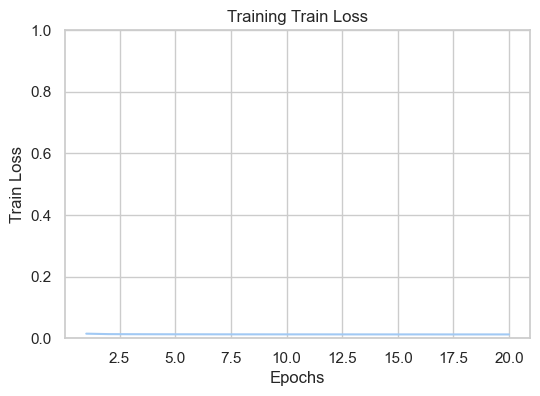

Standard Test


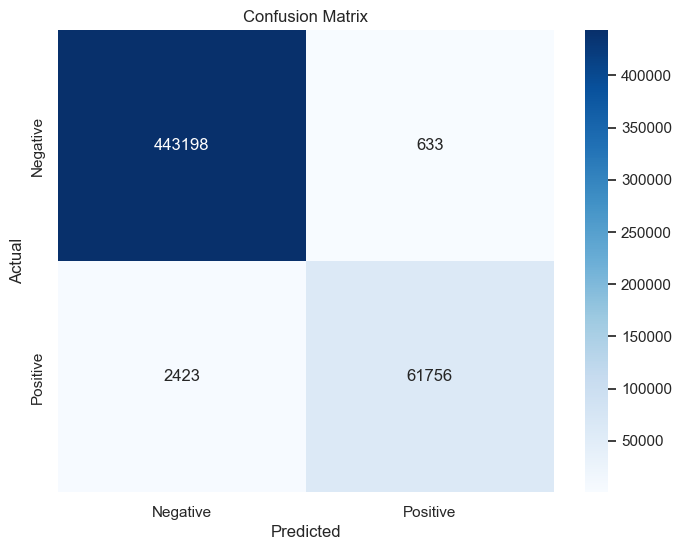

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/001'
modelst2 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.01
epochs = 20
save_factor = 1
modelst2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelst2.test(test_loader)
plot_metrics(modelst2.train_loss, len(modelst2.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelst2.test_predicted)

Epoch 1/10: 100%|██████████| 15876/15876 [02:11<00:00, 120.54batch/s]


Epoch [1/10], Train Loss: 0.0172, Train Acc: 0.9911, Train F1: 0.9909


Epoch 2/10: 100%|██████████| 15876/15876 [02:11<00:00, 121.06batch/s]


Epoch [2/10], Train Loss: 0.0167, Train Acc: 0.9912, Train F1: 0.9910


Epoch 3/10: 100%|██████████| 15876/15876 [02:10<00:00, 121.73batch/s]


Epoch [3/10], Train Loss: 0.0169, Train Acc: 0.9910, Train F1: 0.9908


Epoch 4/10: 100%|██████████| 15876/15876 [02:04<00:00, 127.04batch/s]


Epoch [4/10], Train Loss: 0.0175, Train Acc: 0.9901, Train F1: 0.9899


Epoch 5/10: 100%|██████████| 15876/15876 [02:05<00:00, 126.89batch/s]


Epoch [5/10], Train Loss: 0.0175, Train Acc: 0.9899, Train F1: 0.9896


Epoch 6/10: 100%|██████████| 15876/15876 [02:04<00:00, 127.28batch/s]


Epoch [6/10], Train Loss: 0.0173, Train Acc: 0.9899, Train F1: 0.9896


Epoch 7/10: 100%|██████████| 15876/15876 [02:05<00:00, 126.96batch/s]


Epoch [7/10], Train Loss: 0.0188, Train Acc: 0.9884, Train F1: 0.9880


Epoch 8/10: 100%|██████████| 15876/15876 [02:04<00:00, 127.38batch/s]


Epoch [8/10], Train Loss: 0.0181, Train Acc: 0.9890, Train F1: 0.9887


Epoch 9/10: 100%|██████████| 15876/15876 [02:04<00:00, 127.16batch/s]


Epoch [9/10], Train Loss: 0.0184, Train Acc: 0.9887, Train F1: 0.9883


Epoch 10/10: 100%|██████████| 15876/15876 [02:04<00:00, 127.22batch/s]


Epoch [10/10], Train Loss: 0.0185, Train Acc: 0.9887, Train F1: 0.9883


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 206.12batch/s]


Test Loss: 0.0165, Test Accuracy: 0.9901, Test F1: 0.9898


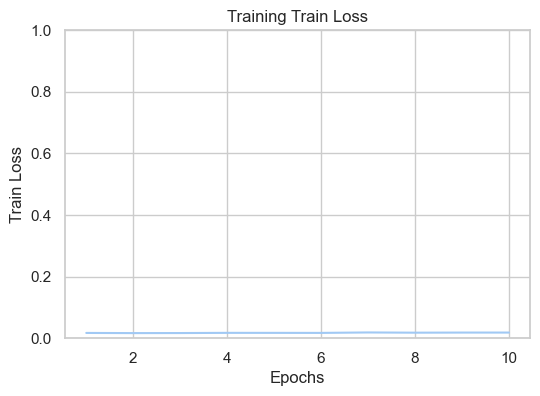

Standard Test


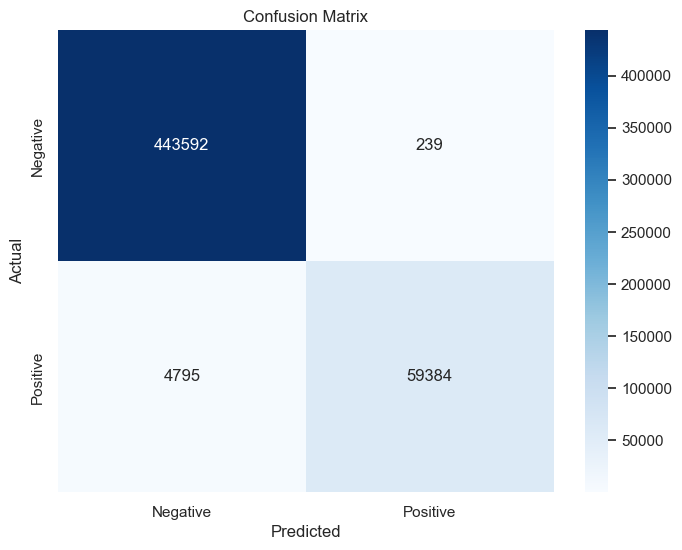

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/09'
modelst3 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.09
epochs = 10
save_factor = 1
modelst3.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelst3.test(test_loader)
plot_metrics(modelst3.train_loss, len(modelst3.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelst3.test_predicted)

Epoch 1/15: 100%|██████████| 15876/15876 [02:07<00:00, 124.71batch/s]


Epoch [1/15], Train Loss: 0.0169, Train Acc: 0.9913, Train F1: 0.9911


Epoch 2/15: 100%|██████████| 15876/15876 [02:12<00:00, 119.82batch/s]


Epoch [2/15], Train Loss: 0.0167, Train Acc: 0.9914, Train F1: 0.9912


Epoch 3/15: 100%|██████████| 15876/15876 [02:12<00:00, 119.80batch/s]


Epoch [3/15], Train Loss: 0.0163, Train Acc: 0.9914, Train F1: 0.9912


Epoch 4/15: 100%|██████████| 15876/15876 [02:12<00:00, 119.86batch/s]


Epoch [4/15], Train Loss: 0.0164, Train Acc: 0.9910, Train F1: 0.9908


Epoch 5/15: 100%|██████████| 15876/15876 [02:08<00:00, 123.47batch/s]


Epoch [5/15], Train Loss: 0.0162, Train Acc: 0.9912, Train F1: 0.9910


Epoch 6/15: 100%|██████████| 15876/15876 [02:04<00:00, 127.38batch/s]


Epoch [6/15], Train Loss: 0.0162, Train Acc: 0.9912, Train F1: 0.9910


Epoch 7/15: 100%|██████████| 15876/15876 [02:04<00:00, 127.26batch/s]


Epoch [7/15], Train Loss: 0.0163, Train Acc: 0.9912, Train F1: 0.9909


Epoch 8/15: 100%|██████████| 15876/15876 [02:04<00:00, 127.32batch/s]


Epoch [8/15], Train Loss: 0.0163, Train Acc: 0.9913, Train F1: 0.9911


Epoch 9/15: 100%|██████████| 15876/15876 [02:04<00:00, 127.28batch/s]


Epoch [9/15], Train Loss: 0.0161, Train Acc: 0.9913, Train F1: 0.9911


Epoch 10/15: 100%|██████████| 15876/15876 [02:10<00:00, 121.87batch/s]


Epoch [10/15], Train Loss: 0.0165, Train Acc: 0.9912, Train F1: 0.9909


Epoch 11/15: 100%|██████████| 15876/15876 [02:12<00:00, 119.89batch/s]


Epoch [11/15], Train Loss: 0.0161, Train Acc: 0.9912, Train F1: 0.9910


Epoch 12/15: 100%|██████████| 15876/15876 [02:12<00:00, 119.92batch/s]


Epoch [12/15], Train Loss: 0.0161, Train Acc: 0.9912, Train F1: 0.9910


Epoch 13/15: 100%|██████████| 15876/15876 [02:06<00:00, 125.20batch/s]


Epoch [13/15], Train Loss: 0.0167, Train Acc: 0.9907, Train F1: 0.9905


Epoch 14/15: 100%|██████████| 15876/15876 [02:04<00:00, 127.46batch/s]


Epoch [14/15], Train Loss: 0.0161, Train Acc: 0.9913, Train F1: 0.9910


Epoch 15/15: 100%|██████████| 15876/15876 [02:04<00:00, 127.57batch/s]


Epoch [15/15], Train Loss: 0.0164, Train Acc: 0.9910, Train F1: 0.9908


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 207.92batch/s]


Test Loss: 0.0193, Test Accuracy: 0.9900, Test F1: 0.9897


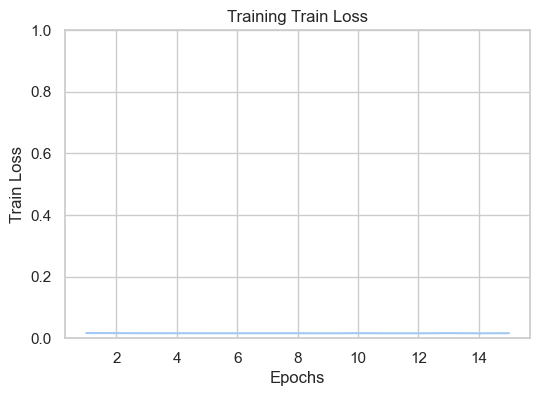

Standard Test


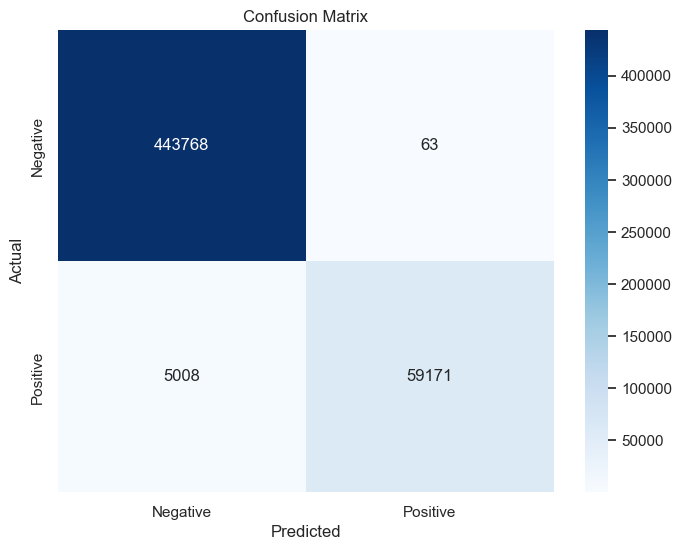

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/08'
modelst4 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.08
epochs = 15
save_factor = 1
modelst4.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelst4.test(test_loader)
plot_metrics(modelst4.train_loss, len(modelst4.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelst4.test_predicted)

Epoch 1/20: 100%|██████████| 15876/15876 [02:04<00:00, 127.45batch/s]


Epoch [1/20], Train Loss: 0.0168, Train Acc: 0.9914, Train F1: 0.9912


Epoch 2/20: 100%|██████████| 15876/15876 [02:03<00:00, 128.36batch/s]


Epoch [2/20], Train Loss: 0.0159, Train Acc: 0.9916, Train F1: 0.9915


Epoch 3/20: 100%|██████████| 15876/15876 [02:06<00:00, 125.80batch/s]


Epoch [3/20], Train Loss: 0.0159, Train Acc: 0.9917, Train F1: 0.9915


Epoch 4/20: 100%|██████████| 15876/15876 [02:13<00:00, 119.32batch/s]


Epoch [4/20], Train Loss: 0.0158, Train Acc: 0.9916, Train F1: 0.9914


Epoch 5/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.95batch/s]


Epoch [5/20], Train Loss: 0.0159, Train Acc: 0.9915, Train F1: 0.9913


Epoch 6/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.36batch/s]


Epoch [6/20], Train Loss: 0.0157, Train Acc: 0.9917, Train F1: 0.9914


Epoch 7/20: 100%|██████████| 15876/15876 [02:07<00:00, 124.40batch/s]


Epoch [7/20], Train Loss: 0.0157, Train Acc: 0.9917, Train F1: 0.9915


Epoch 8/20: 100%|██████████| 15876/15876 [02:06<00:00, 125.90batch/s]


Epoch [8/20], Train Loss: 0.0158, Train Acc: 0.9916, Train F1: 0.9914


Epoch 9/20: 100%|██████████| 15876/15876 [02:06<00:00, 125.39batch/s]


Epoch [9/20], Train Loss: 0.0158, Train Acc: 0.9914, Train F1: 0.9912


Epoch 10/20: 100%|██████████| 15876/15876 [02:06<00:00, 125.95batch/s]


Epoch [10/20], Train Loss: 0.0158, Train Acc: 0.9914, Train F1: 0.9912


Epoch 11/20: 100%|██████████| 15876/15876 [02:10<00:00, 122.08batch/s]


Epoch [11/20], Train Loss: 0.0158, Train Acc: 0.9915, Train F1: 0.9912


Epoch 12/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.44batch/s]


Epoch [12/20], Train Loss: 0.0159, Train Acc: 0.9913, Train F1: 0.9911


Epoch 13/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.63batch/s]


Epoch [13/20], Train Loss: 0.0156, Train Acc: 0.9917, Train F1: 0.9915


Epoch 14/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.70batch/s]


Epoch [14/20], Train Loss: 0.0157, Train Acc: 0.9915, Train F1: 0.9913


Epoch 15/20: 100%|██████████| 15876/15876 [02:06<00:00, 125.80batch/s]


Epoch [15/20], Train Loss: 0.0157, Train Acc: 0.9914, Train F1: 0.9912


Epoch 16/20: 100%|██████████| 15876/15876 [02:05<00:00, 126.18batch/s]


Epoch [16/20], Train Loss: 0.0161, Train Acc: 0.9910, Train F1: 0.9908


Epoch 17/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.70batch/s]


Epoch [17/20], Train Loss: 0.0160, Train Acc: 0.9914, Train F1: 0.9912


Epoch 18/20: 100%|██████████| 15876/15876 [02:10<00:00, 121.21batch/s]


Epoch [18/20], Train Loss: 0.0157, Train Acc: 0.9915, Train F1: 0.9912


Epoch 19/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.87batch/s]


Epoch [19/20], Train Loss: 0.0156, Train Acc: 0.9917, Train F1: 0.9915


Epoch 20/20: 100%|██████████| 15876/15876 [02:05<00:00, 126.16batch/s]


Epoch [20/20], Train Loss: 0.0158, Train Acc: 0.9916, Train F1: 0.9914


Testing: 100%|██████████| 3969/3969 [00:21<00:00, 183.93batch/s]


Test Loss: 0.0163, Test Accuracy: 0.9908, Test F1: 0.9905


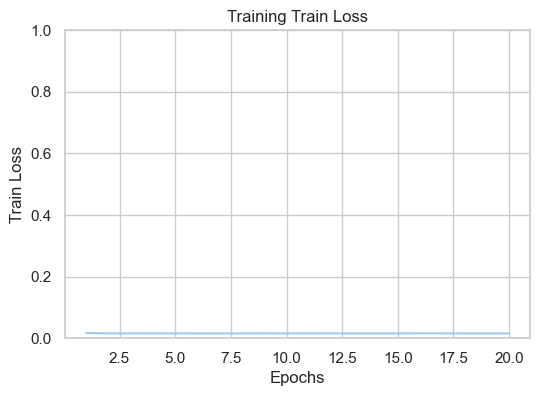

Standard Test


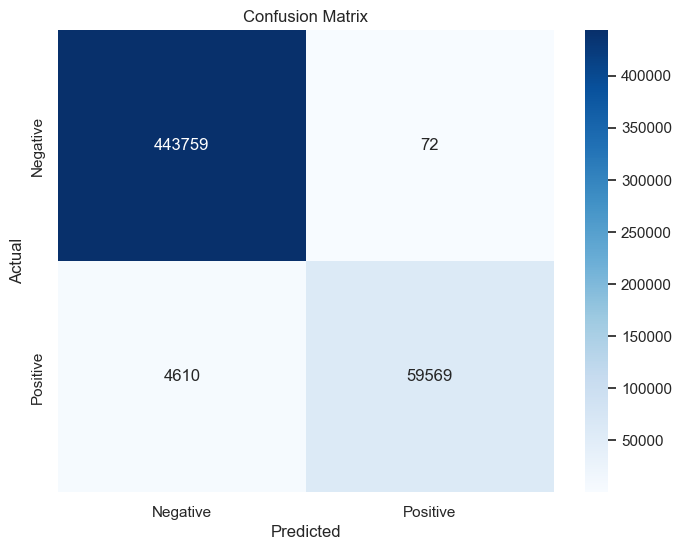

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/standard/07'
modelst5 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.07
epochs = 20
save_factor = 1
modelst5.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelst5.test(test_loader)
plot_metrics(modelst5.train_loss, len(modelst5.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelst5.test_predicted)

# Layer

Epoch 1/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.20batch/s]


Epoch [1/20], Train Loss: 0.0174, Train Acc: 0.9911, Train F1: 0.9909


Epoch 2/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.05batch/s]


Epoch [2/20], Train Loss: 0.0164, Train Acc: 0.9913, Train F1: 0.9911


Epoch 3/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.33batch/s]


Epoch [3/20], Train Loss: 0.0164, Train Acc: 0.9913, Train F1: 0.9910


Epoch 4/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.57batch/s]


Epoch [4/20], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9909


Epoch 5/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.71batch/s]


Epoch [5/20], Train Loss: 0.0162, Train Acc: 0.9913, Train F1: 0.9911


Epoch 6/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.69batch/s]


Epoch [6/20], Train Loss: 0.0161, Train Acc: 0.9912, Train F1: 0.9909


Epoch 7/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.68batch/s]


Epoch [7/20], Train Loss: 0.0164, Train Acc: 0.9910, Train F1: 0.9908


Epoch 8/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.19batch/s]


Epoch [8/20], Train Loss: 0.0162, Train Acc: 0.9914, Train F1: 0.9912


Epoch 9/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.21batch/s]


Epoch [9/20], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9909


Epoch 10/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.29batch/s]


Epoch [10/20], Train Loss: 0.0162, Train Acc: 0.9912, Train F1: 0.9909


Epoch 11/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.15batch/s]


Epoch [11/20], Train Loss: 0.0161, Train Acc: 0.9913, Train F1: 0.9910


Epoch 12/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.34batch/s]


Epoch [12/20], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9908


Epoch 13/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.91batch/s]


Epoch [13/20], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9909


Epoch 14/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.71batch/s]


Epoch [14/20], Train Loss: 0.0161, Train Acc: 0.9914, Train F1: 0.9912


Epoch 15/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.73batch/s]


Epoch [15/20], Train Loss: 0.0162, Train Acc: 0.9913, Train F1: 0.9910


Epoch 16/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.07batch/s]


Epoch [16/20], Train Loss: 0.0161, Train Acc: 0.9914, Train F1: 0.9911


Epoch 17/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.37batch/s]


Epoch [17/20], Train Loss: 0.0165, Train Acc: 0.9911, Train F1: 0.9909


Epoch 18/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.86batch/s]


Epoch [18/20], Train Loss: 0.0163, Train Acc: 0.9911, Train F1: 0.9909


Epoch 19/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.86batch/s]


Epoch [19/20], Train Loss: 0.0164, Train Acc: 0.9912, Train F1: 0.9910


Epoch 20/20: 100%|██████████| 15876/15876 [02:11<00:00, 121.09batch/s]


Epoch [20/20], Train Loss: 0.0163, Train Acc: 0.9912, Train F1: 0.9910


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 207.40batch/s]


Test Loss: 0.0157, Test Accuracy: 0.9918, Test F1: 0.9916


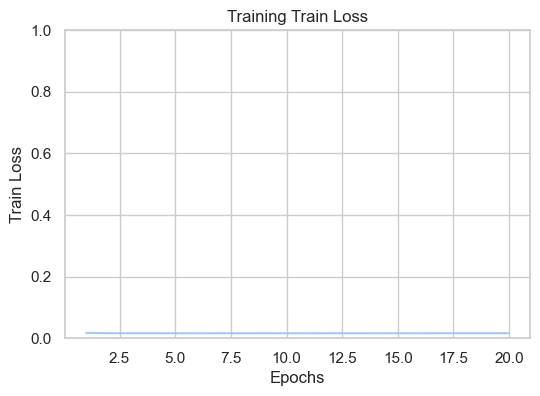

Standard Test


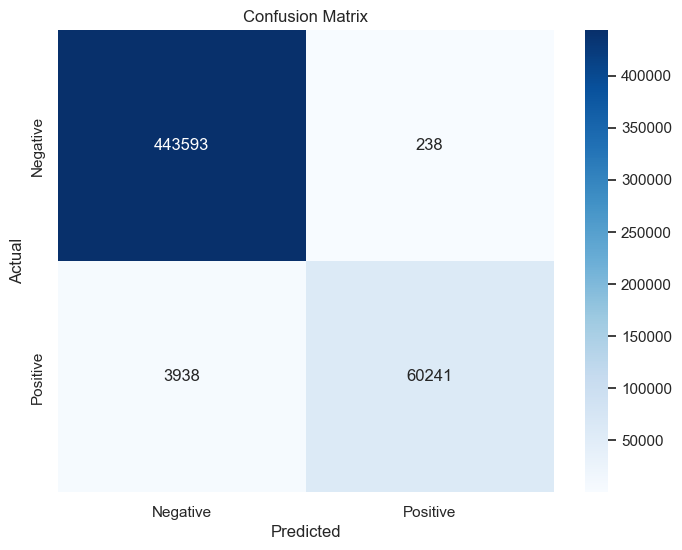

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 256
save_dir = './Models/saved_models/02/standard/07L256'
modellt1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.08
epochs = 20
save_factor = 1
modellt1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modellt1.test(test_loader)
plot_metrics(modellt1.train_loss, len(modellt1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modellt1.test_predicted)

Epoch 1/20: 100%|██████████| 15876/15876 [02:11<00:00, 121.06batch/s]


Epoch [1/20], Train Loss: 0.0179, Train Acc: 0.9907, Train F1: 0.9904


Epoch 2/20: 100%|██████████| 15876/15876 [02:10<00:00, 121.21batch/s]


Epoch [2/20], Train Loss: 0.0165, Train Acc: 0.9914, Train F1: 0.9912


Epoch 3/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.86batch/s]


Epoch [3/20], Train Loss: 0.0166, Train Acc: 0.9913, Train F1: 0.9911


Epoch 4/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.69batch/s]


Epoch [4/20], Train Loss: 0.0164, Train Acc: 0.9914, Train F1: 0.9912


Epoch 5/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.71batch/s]


Epoch [5/20], Train Loss: 0.0163, Train Acc: 0.9914, Train F1: 0.9912


Epoch 6/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.99batch/s]


Epoch [6/20], Train Loss: 0.0162, Train Acc: 0.9912, Train F1: 0.9910


Epoch 7/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.43batch/s]


Epoch [7/20], Train Loss: 0.0163, Train Acc: 0.9912, Train F1: 0.9909


Epoch 8/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.67batch/s]


Epoch [8/20], Train Loss: 0.0162, Train Acc: 0.9912, Train F1: 0.9909


Epoch 9/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.37batch/s]


Epoch [9/20], Train Loss: 0.0162, Train Acc: 0.9913, Train F1: 0.9910


Epoch 10/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.07batch/s]


Epoch [10/20], Train Loss: 0.0163, Train Acc: 0.9913, Train F1: 0.9911


Epoch 11/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.03batch/s]


Epoch [11/20], Train Loss: 0.0164, Train Acc: 0.9913, Train F1: 0.9910


Epoch 12/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.69batch/s]


Epoch [12/20], Train Loss: 0.0162, Train Acc: 0.9914, Train F1: 0.9912


Epoch 13/20: 100%|██████████| 15876/15876 [02:12<00:00, 119.68batch/s]


Epoch [13/20], Train Loss: 0.0162, Train Acc: 0.9911, Train F1: 0.9909


Epoch 14/20: 100%|██████████| 15876/15876 [02:11<00:00, 120.93batch/s]


Epoch [14/20], Train Loss: 0.0164, Train Acc: 0.9911, Train F1: 0.9908


Epoch 15/20: 100%|██████████| 15876/15876 [02:10<00:00, 121.71batch/s]


Epoch [15/20], Train Loss: 0.0163, Train Acc: 0.9912, Train F1: 0.9910


Epoch 16/20: 100%|██████████| 15876/15876 [02:10<00:00, 121.42batch/s]


Epoch [16/20], Train Loss: 0.0162, Train Acc: 0.9913, Train F1: 0.9911


Epoch 17/20: 100%|██████████| 15876/15876 [02:10<00:00, 122.05batch/s]


Epoch [17/20], Train Loss: 0.0162, Train Acc: 0.9913, Train F1: 0.9911


Epoch 18/20: 100%|██████████| 15876/15876 [02:09<00:00, 122.15batch/s]


Epoch [18/20], Train Loss: 0.0161, Train Acc: 0.9915, Train F1: 0.9913


Epoch 19/20: 100%|██████████| 15876/15876 [02:12<00:00, 120.15batch/s]


Epoch [19/20], Train Loss: 0.0164, Train Acc: 0.9913, Train F1: 0.9910


Epoch 20/20: 100%|██████████| 15876/15876 [02:09<00:00, 122.27batch/s]


Epoch [20/20], Train Loss: 0.0166, Train Acc: 0.9909, Train F1: 0.9906


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 202.56batch/s]


Test Loss: 0.0165, Test Accuracy: 0.9925, Test F1: 0.9923


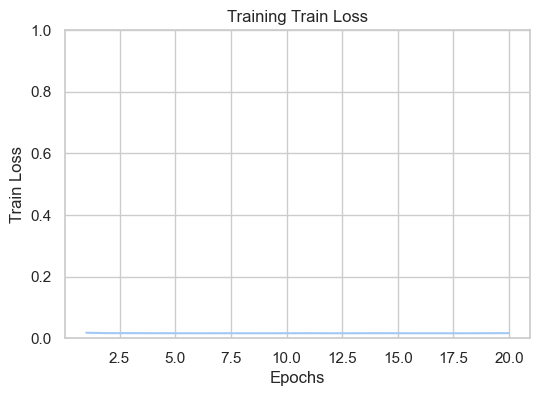

Standard Test


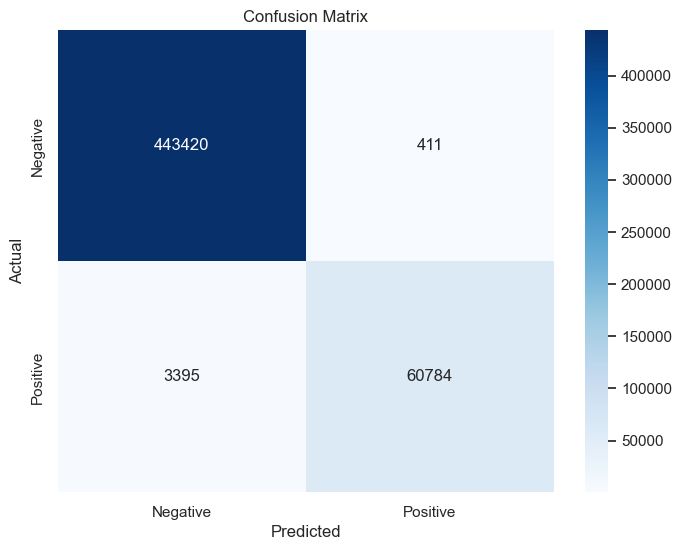

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 512
save_dir = './Models/saved_models/02/standard/09L512'
modellt2 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.08
epochs = 20
save_factor = 1
modellt2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modellt2.test(test_loader)
plot_metrics(modellt2.train_loss, len(modellt2.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modellt2.test_predicted)

Epoch 1/5: 100%|██████████| 15876/15876 [02:11<00:00, 120.62batch/s]


Epoch [1/5], Train Loss: 0.0192, Train Acc: 0.9908, Train F1: 0.9905


Epoch 2/5: 100%|██████████| 15876/15876 [02:12<00:00, 119.79batch/s]


Epoch [2/5], Train Loss: 0.0177, Train Acc: 0.9898, Train F1: 0.9895


Epoch 3/5: 100%|██████████| 15876/15876 [02:12<00:00, 119.74batch/s]


Epoch [3/5], Train Loss: 0.0170, Train Acc: 0.9907, Train F1: 0.9904


Epoch 4/5: 100%|██████████| 15876/15876 [02:12<00:00, 119.71batch/s]


Epoch [4/5], Train Loss: 0.0171, Train Acc: 0.9904, Train F1: 0.9902


Epoch 5/5: 100%|██████████| 15876/15876 [02:11<00:00, 120.68batch/s]


Epoch [5/5], Train Loss: 0.0177, Train Acc: 0.9894, Train F1: 0.9890


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 198.48batch/s]

Test Loss: 0.0171, Test Accuracy: 0.9895, Test F1: 0.9892


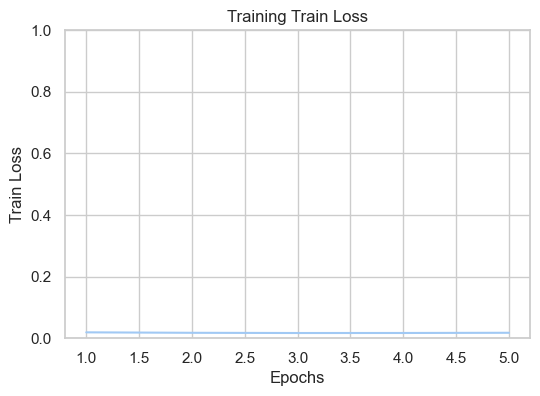

Standard Test


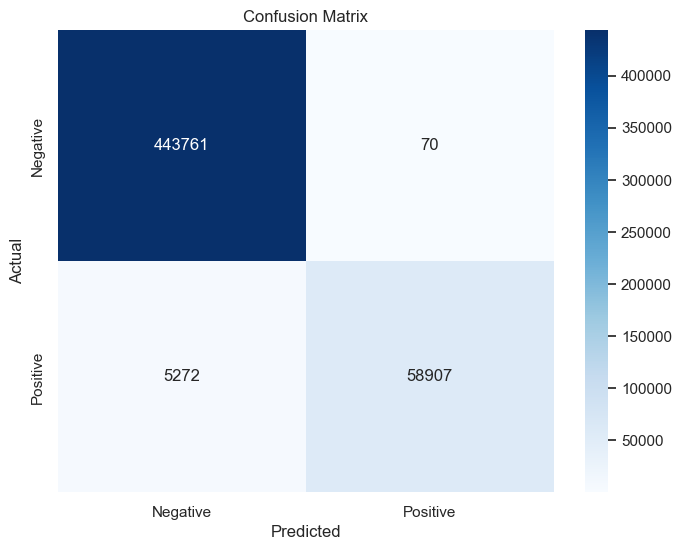

In [ ]:
# This is actually a potential candidate for further tests, the loss continues to decrease without reverting. This is looks like the almost inverse of SMOTE.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 512
save_dir = './Models/saved_models/02/standard/1L512'
modellt3 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = None
params = None
learning_rate = 0.1
epochs = 5
save_factor = 1
modellt3.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modellt3.test(test_loader)
plot_metrics(modellt3.train_loss, len(modellt3.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modellt3.test_predicted)

Result: Nothing we do in terms of tuning seems to have a significant effect on minority labels.

# SMOTE TUNING

Layers on best current model.

Epoch 1/5: 100%|██████████| 15876/15876 [04:28<00:00, 59.21batch/s]


Epoch [1/5], Train Loss: 0.0205, Train Acc: 0.9915, Train F1: 0.9915


Epoch 2/5: 100%|██████████| 15876/15876 [04:27<00:00, 59.37batch/s]


Epoch [2/5], Train Loss: 0.0168, Train Acc: 0.9917, Train F1: 0.9917


Epoch 3/5: 100%|██████████| 15876/15876 [04:28<00:00, 59.11batch/s]


Epoch [3/5], Train Loss: 0.0176, Train Acc: 0.9922, Train F1: 0.9922


Epoch 4/5: 100%|██████████| 15876/15876 [04:27<00:00, 59.29batch/s]


Epoch [4/5], Train Loss: 0.0200, Train Acc: 0.9924, Train F1: 0.9924


Epoch 5/5: 100%|██████████| 15876/15876 [04:27<00:00, 59.40batch/s]


Epoch [5/5], Train Loss: 0.0182, Train Acc: 0.9922, Train F1: 0.9922


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 205.44batch/s]


Test Loss: 0.0348, Test Accuracy: 0.9879, Test F1: 0.9883


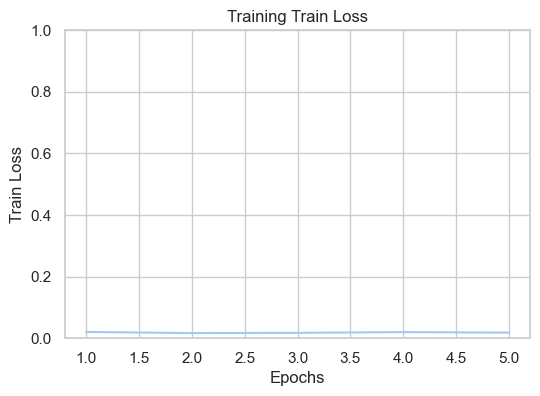

Standard Test


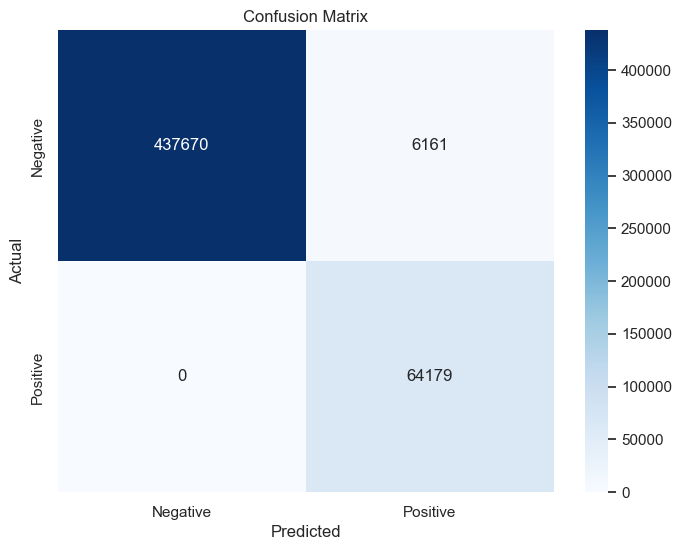

In [ ]:
# Odd Errors? - didn't really encounter these before..
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote/01-128'
modelsm1 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
# This can be tuned to percentatage but we risk not classifying all threats.
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
modelsm1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelsm1.test(test_loader)
plot_metrics(modelsm1.train_loss, len(modelsm1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelsm1.test_predicted)

Epoch 1/5: 100%|██████████| 15876/15876 [04:36<00:00, 57.47batch/s]


Epoch [1/5], Train Loss: 0.0238, Train Acc: 0.9916, Train F1: 0.9915


Epoch 2/5: 100%|██████████| 15876/15876 [04:37<00:00, 57.25batch/s]


Epoch [2/5], Train Loss: 0.0168, Train Acc: 0.9916, Train F1: 0.9916


Epoch 3/5: 100%|██████████| 15876/15876 [04:39<00:00, 56.76batch/s]


Epoch [3/5], Train Loss: 0.0181, Train Acc: 0.9921, Train F1: 0.9921


Epoch 4/5: 100%|██████████| 15876/15876 [04:37<00:00, 57.23batch/s]


Epoch [4/5], Train Loss: 0.0188, Train Acc: 0.9923, Train F1: 0.9923


Epoch 5/5: 100%|██████████| 15876/15876 [04:34<00:00, 57.77batch/s]


Epoch [5/5], Train Loss: 0.0189, Train Acc: 0.9921, Train F1: 0.9921


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 201.65batch/s]


Test Loss: 0.0191, Test Accuracy: 0.9919, Test F1: 0.9919


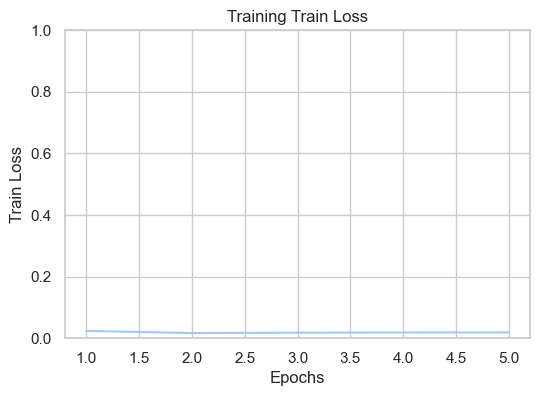

Standard Test


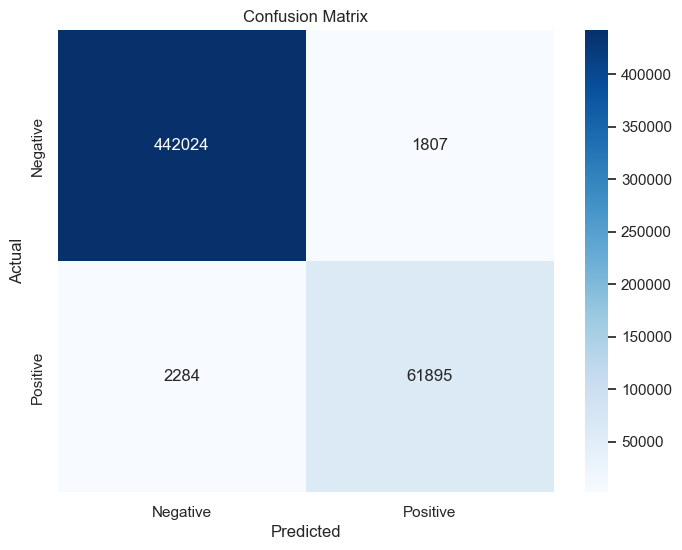

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 256
save_dir = './Models/saved_models/02/smote/01-256'
modelsm2 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
modelsm2.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelsm2.test(test_loader)
plot_metrics(modelsm2.train_loss, len(modelsm2.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelsm2.test_predicted)

Epoch 1/5: 100%|██████████| 15876/15876 [04:42<00:00, 56.18batch/s]


Epoch [1/5], Train Loss: 0.0370, Train Acc: 0.9916, Train F1: 0.9916


Epoch 2/5: 100%|██████████| 15876/15876 [04:44<00:00, 55.77batch/s]


Epoch [2/5], Train Loss: 0.0174, Train Acc: 0.9917, Train F1: 0.9917


Epoch 3/5: 100%|██████████| 15876/15876 [04:38<00:00, 57.00batch/s]


Epoch [3/5], Train Loss: 0.0186, Train Acc: 0.9920, Train F1: 0.9920


Epoch 4/5: 100%|██████████| 15876/15876 [04:38<00:00, 56.92batch/s]


Epoch [4/5], Train Loss: 0.0214, Train Acc: 0.9927, Train F1: 0.9927


Epoch 5/5: 100%|██████████| 15876/15876 [04:40<00:00, 56.68batch/s]


Epoch [5/5], Train Loss: 0.0187, Train Acc: 0.9921, Train F1: 0.9921


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 198.58batch/s]


Test Loss: 0.0243, Test Accuracy: 0.9874, Test F1: 0.9879


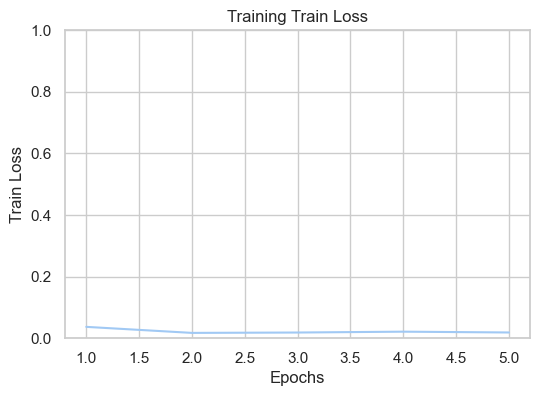

Standard Test


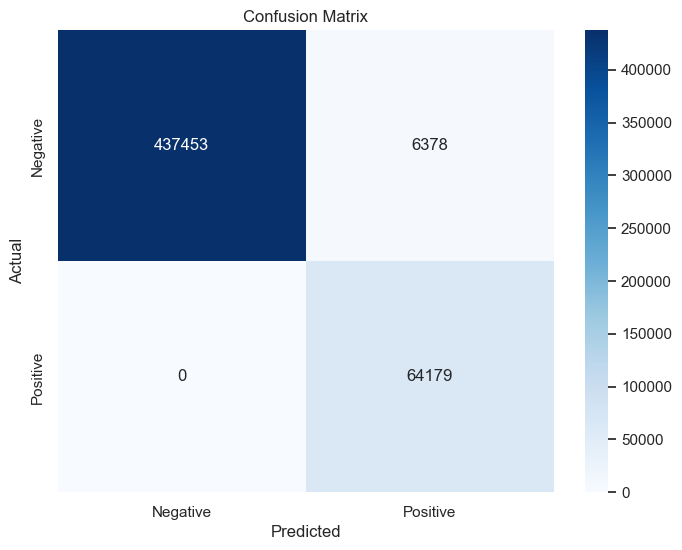

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 512
save_dir = './Models/saved_models/02/smote/01-512'
modelsm3 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.1
epochs = 5
save_factor = 1
modelsm3.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelsm3.test(test_loader)
plot_metrics(modelsm3.train_loss, len(modelsm3.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelsm3.test_predicted)

LR and Epochs

Epoch 1/5: 100%|██████████| 15876/15876 [04:28<00:00, 59.15batch/s]


Epoch [1/5], Train Loss: 0.0185, Train Acc: 0.9912, Train F1: 0.9912


Epoch 2/5: 100%|██████████| 15876/15876 [04:28<00:00, 59.20batch/s]


Epoch [2/5], Train Loss: 0.0169, Train Acc: 0.9918, Train F1: 0.9918


Epoch 3/5: 100%|██████████| 15876/15876 [04:27<00:00, 59.34batch/s]


Epoch [3/5], Train Loss: 0.0196, Train Acc: 0.9911, Train F1: 0.9911


Epoch 4/5: 100%|██████████| 15876/15876 [04:27<00:00, 59.41batch/s]


Epoch [4/5], Train Loss: 0.0198, Train Acc: 0.9904, Train F1: 0.9904


Epoch 5/5: 100%|██████████| 15876/15876 [04:27<00:00, 59.35batch/s]


Epoch [5/5], Train Loss: 0.0209, Train Acc: 0.9910, Train F1: 0.9909


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 202.19batch/s]

Test Loss: 0.0216, Test Accuracy: 0.9869, Test F1: 0.9873


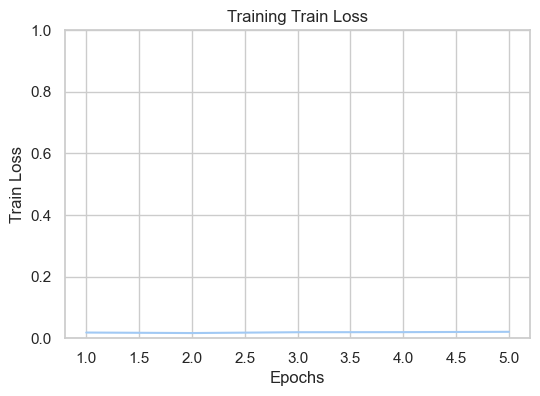

Standard Test


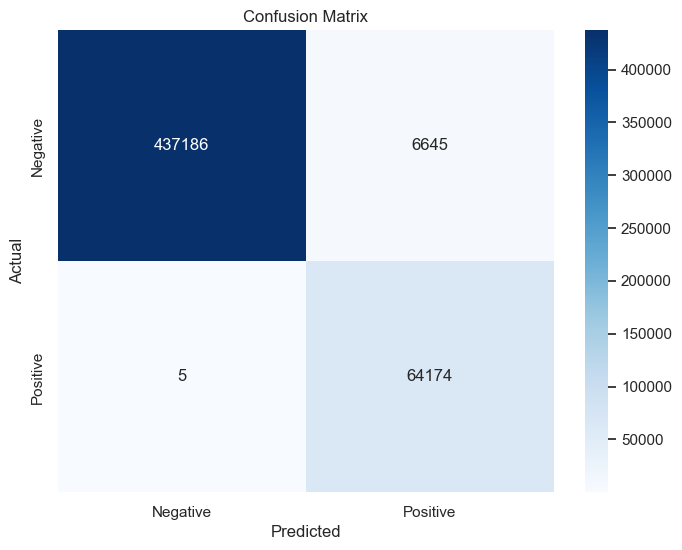

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote/009-128'
modelsm4 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.09
epochs = 5
save_factor = 1
modelsm4.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelsm4.test(test_loader)
plot_metrics(modelsm4.train_loss, len(modelsm4.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelsm4.test_predicted)

Epoch 1/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.29batch/s]


Epoch [1/15], Train Loss: 0.0176, Train Acc: 0.9918, Train F1: 0.9918


Epoch 2/15: 100%|██████████| 15876/15876 [04:26<00:00, 59.49batch/s]


Epoch [2/15], Train Loss: 0.0163, Train Acc: 0.9920, Train F1: 0.9920


Epoch 3/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.38batch/s]


Epoch [3/15], Train Loss: 0.0169, Train Acc: 0.9922, Train F1: 0.9922


Epoch 4/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.39batch/s]


Epoch [4/15], Train Loss: 0.0190, Train Acc: 0.9925, Train F1: 0.9925


Epoch 5/15: 100%|██████████| 15876/15876 [04:28<00:00, 59.04batch/s]


Epoch [5/15], Train Loss: 0.0169, Train Acc: 0.9922, Train F1: 0.9921


Epoch 6/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.28batch/s]


Epoch [6/15], Train Loss: 0.0183, Train Acc: 0.9924, Train F1: 0.9923


Epoch 7/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.42batch/s]


Epoch [7/15], Train Loss: 0.0194, Train Acc: 0.9925, Train F1: 0.9925


Epoch 8/15: 100%|██████████| 15876/15876 [04:26<00:00, 59.54batch/s]


Epoch [8/15], Train Loss: 0.0184, Train Acc: 0.9925, Train F1: 0.9925


Epoch 9/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.31batch/s]


Epoch [9/15], Train Loss: 0.0176, Train Acc: 0.9924, Train F1: 0.9924


Epoch 10/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.28batch/s]


Epoch [10/15], Train Loss: 0.0189, Train Acc: 0.9925, Train F1: 0.9925


Epoch 11/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.45batch/s]


Epoch [11/15], Train Loss: 0.0186, Train Acc: 0.9925, Train F1: 0.9925


Epoch 12/15: 100%|██████████| 15876/15876 [04:26<00:00, 59.48batch/s]


Epoch [12/15], Train Loss: 0.0197, Train Acc: 0.9925, Train F1: 0.9925


Epoch 13/15: 100%|██████████| 15876/15876 [04:26<00:00, 59.49batch/s]


Epoch [13/15], Train Loss: 0.0193, Train Acc: 0.9925, Train F1: 0.9925


Epoch 14/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.37batch/s]


Epoch [14/15], Train Loss: 0.0180, Train Acc: 0.9924, Train F1: 0.9924


Epoch 15/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.26batch/s]


Epoch [15/15], Train Loss: 0.0192, Train Acc: 0.9926, Train F1: 0.9925


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 203.60batch/s]


Test Loss: 0.0306, Test Accuracy: 0.9878, Test F1: 0.9882


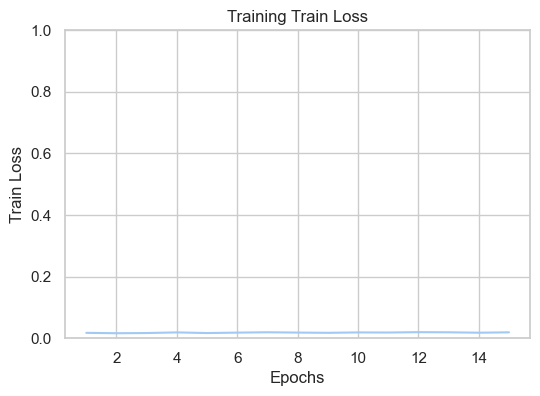

Standard Test


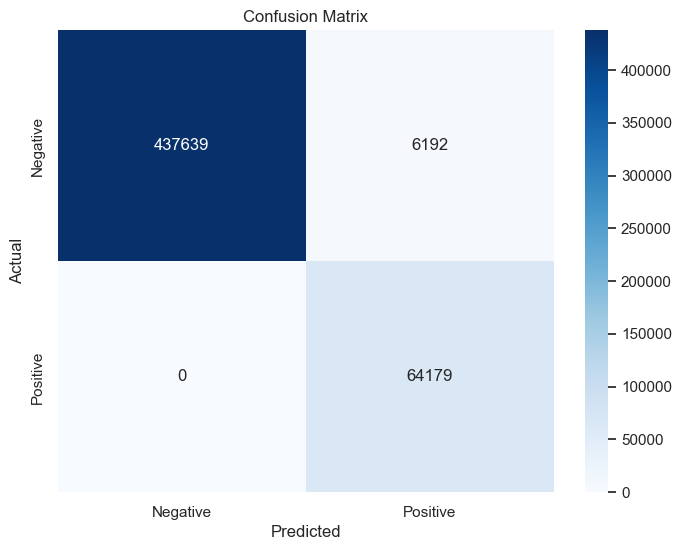

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote/008-256'
modelsm5 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.08
epochs = 15
save_factor = 1
modelsm5.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelsm5.test(test_loader)
plot_metrics(modelsm5.train_loss, len(modelsm5.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelsm5.test_predicted)

Epoch 1/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.32batch/s]


Epoch [1/15], Train Loss: 0.0167, Train Acc: 0.9918, Train F1: 0.9918


Epoch 2/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.31batch/s]


Epoch [2/15], Train Loss: 0.0155, Train Acc: 0.9921, Train F1: 0.9921


Epoch 3/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.34batch/s]


Epoch [3/15], Train Loss: 0.0168, Train Acc: 0.9924, Train F1: 0.9924


Epoch 4/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.24batch/s]


Epoch [4/15], Train Loss: 0.0162, Train Acc: 0.9923, Train F1: 0.9923


Epoch 5/15: 100%|██████████| 15876/15876 [04:26<00:00, 59.50batch/s]


Epoch [5/15], Train Loss: 0.0169, Train Acc: 0.9923, Train F1: 0.9923


Epoch 6/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.41batch/s]


Epoch [6/15], Train Loss: 0.0173, Train Acc: 0.9922, Train F1: 0.9922


Epoch 7/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.40batch/s]


Epoch [7/15], Train Loss: 0.0163, Train Acc: 0.9922, Train F1: 0.9922


Epoch 8/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.33batch/s]


Epoch [8/15], Train Loss: 0.0185, Train Acc: 0.9924, Train F1: 0.9924


Epoch 9/15: 100%|██████████| 15876/15876 [04:28<00:00, 59.23batch/s]


Epoch [9/15], Train Loss: 0.0164, Train Acc: 0.9922, Train F1: 0.9922


Epoch 10/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.39batch/s]


Epoch [10/15], Train Loss: 0.0180, Train Acc: 0.9923, Train F1: 0.9923


Epoch 11/15: 100%|██████████| 15876/15876 [04:26<00:00, 59.53batch/s]


Epoch [11/15], Train Loss: 0.0174, Train Acc: 0.9924, Train F1: 0.9924


Epoch 12/15: 100%|██████████| 15876/15876 [04:45<00:00, 55.63batch/s]


Epoch [12/15], Train Loss: 0.0174, Train Acc: 0.9923, Train F1: 0.9923


Epoch 13/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.32batch/s]


Epoch [13/15], Train Loss: 0.0173, Train Acc: 0.9921, Train F1: 0.9921


Epoch 14/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.46batch/s]


Epoch [14/15], Train Loss: 0.0183, Train Acc: 0.9923, Train F1: 0.9923


Epoch 15/15: 100%|██████████| 15876/15876 [04:27<00:00, 59.37batch/s]


Epoch [15/15], Train Loss: 0.0190, Train Acc: 0.9925, Train F1: 0.9925


Testing: 100%|██████████| 3969/3969 [00:19<00:00, 207.51batch/s]


Test Loss: 0.0319, Test Accuracy: 0.9874, Test F1: 0.9878


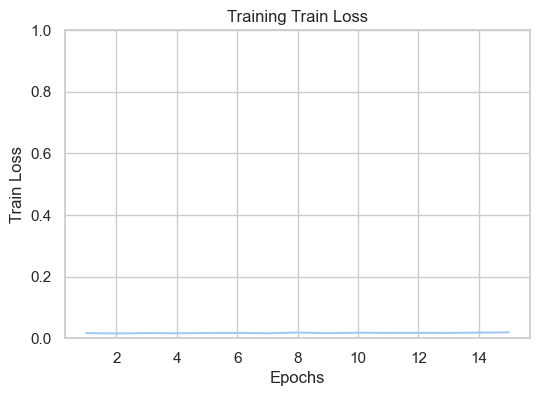

Standard Test


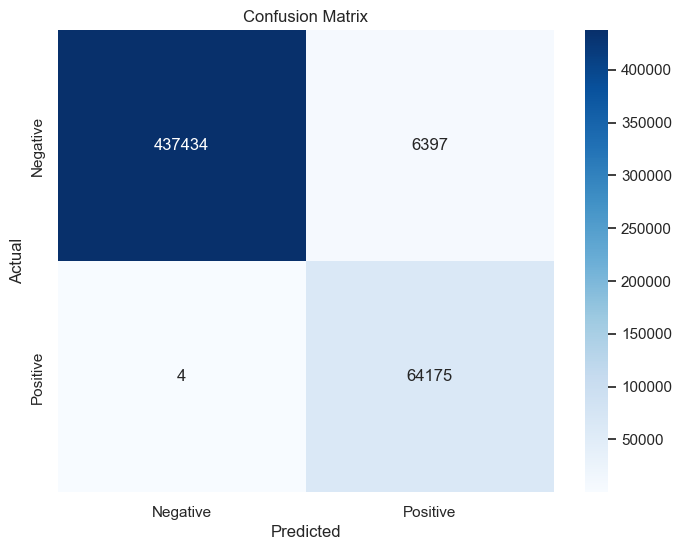

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/02/smote/007-128'
modelsm6 = NNdynamic(n_features, fc_size, device, save_dir)
# 37.23 min
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
learning_rate = 0.07
epochs = 15
save_factor = 1
modelsm6.run(train_loader, learning_rate, epochs, save_factor, sampler, params, False)
modelsm6.test(test_loader)
plot_metrics(modelsm6.train_loss, len(modelsm6.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, modelsm6.test_predicted)

c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\Code\Models\models.py:262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_stat

Test Loss: 0.0319, Test Accuracy: 0.9874, Test F1: 0.9878


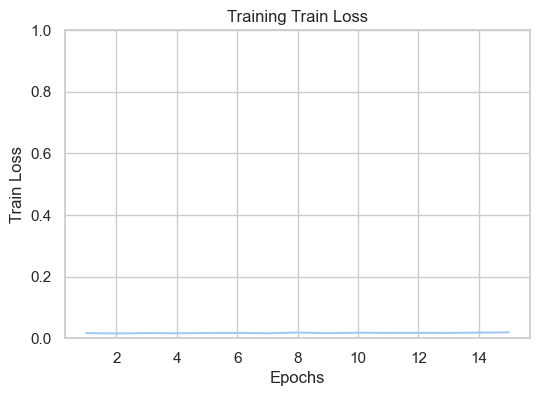

Standard Test


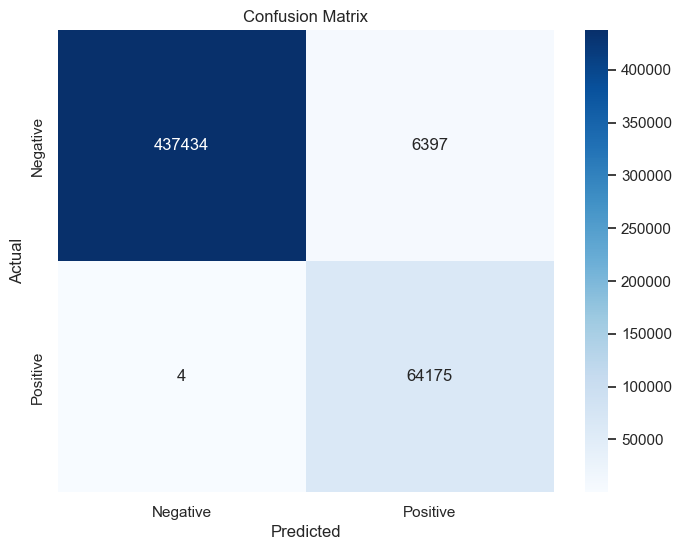

In [24]:
model1.load_model('./Models/saved_models/02/smote/007-128/PB_epoch_15.pth')
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
print('Standard Test')
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)